# **Exploratory Data Analysis**
* Previousely, We examined the various tables in the database to identify key variables, understand, their realationships, and determine which one should be inclueded in final analysis.
* In this phase, We are exploring the resultant table to gain insights into the distribution of each column.
* This will enable us to discover underlying patterns and valuable insights.

>### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

>### Establishing connection with **MySQL** Data-Base

In [2]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "root"  # your MySQL username
password = "tictok#2020"
host = "localhost"  # your MySQL server IP
port = "3306"
database = "contoso_sales"

try:
    engine = create_engine(
        f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
    )
except Exception as exc:
    print("Error while connecting to mysql", exc)

>### Loading Data-Set

In [3]:
sql_query = """
    SELECT * FROM sales_summary;
"""

df = pd.read_sql(sql=sql_query, con=engine)
df.head()

,id,dates,years,quarters,channel_name,brand_name,continent_name,country_name,product_category_name,return_amount,discount_amount,total_cost,total_sales,net_sales,net_profit,profit_margin
0,1,2007-01-01,2007,Q1,Store,Contoso,Asia,China,Audio,0.00,6.47,66.00,129.42,122.95,56.95,46.32
1,2,2007-01-01,2007,Q1,Store,Contoso,Europe,United Kingdom,Audio,299.23,119.69,793.12,2393.84,1974.92,1181.80,59.84
2,3,2007-01-01,2007,Q1,Store,Contoso,North America,United States,Audio,0.00,14.96,892.26,2693.07,2678.11,1785.85,66.68
3,4,2007-01-01,2007,Q1,Store,Wide World Importers,Europe,Romania,Audio,0.00,0.00,305.80,599.80,599.80,294.00,49.02
4,5,2007-01-01,2007,Q1,Store,Wide World Importers,Europe,Slovenia,Audio,149.95,29.99,305.80,599.80,419.86,114.06,27.17


>### Data Structrue Overview

In [ ]:
# Shape of the Data-Set
df.shape

(348484, 16)

In [ ]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(0)

In [24]:
# Shows columns, Null values and Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348484 entries, 0 to 348483
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     348484 non-null  int64  
 1   dates                  348484 non-null  object 
 2   years                  348484 non-null  object 
 3   quarters               348484 non-null  object 
 4   channel_name           348484 non-null  object 
 5   brand_name             348484 non-null  object 
 6   continent_name         348484 non-null  object 
 7   country_name           348484 non-null  object 
 8   product_category_name  348484 non-null  object 
 9   return_amount          348484 non-null  float64
 10  discount_amount        348484 non-null  float64
 11  total_cost             348484 non-null  float64
 12  total_sales            348484 non-null  float64
 13  net_sales              348484 non-null  float64
 14  net_profit             348484 non-nu

In [ ]:
# Checking for number of unique values in each feature or column
df.nunique().sort_values()

years                         3
continent_name                3
channel_name                  4
quarters                      4
product_category_name         8
brand_name                   11
country_name                 34
dates                      1096
return_amount              6904
profit_margin             12001
total_sales               15811
total_cost                18826
discount_amount           37447
net_sales                115758
net_profit               120561
id                       348484
dtype: int64

>### Data Cleaning & Handling Missing Values

In [27]:
# Removing duplicate if present
df.drop_duplicates(inplace=True)

In [28]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False)

id                       0
dates                    0
years                    0
quarters                 0
channel_name             0
brand_name               0
continent_name           0
country_name             0
product_category_name    0
return_amount            0
discount_amount          0
total_cost               0
total_sales              0
net_sales                0
net_profit               0
profit_margin            0
dtype: int64

>### Summary Statstics

In [20]:
df.describe()

,id,return_amount,discount_amount,total_cost,total_sales,net_sales,net_profit,profit_margin
count,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000,348484.000000
mean,174242.500000,118.343921,153.453132,2386.724938,5352.136380,5080.339328,2693.614389,51.770290
std,100598.809942,371.478190,386.307736,3118.632076,7116.969491,6850.342649,3896.504499,1383.188999
min,1.000000,0.000000,0.000000,1.920000,3.800000,-8791.870000,-9515.770000,-260665.220000
25%,87121.750000,0.000000,0.000000,521.640000,1079.910000,980.000000,457.390000,47.230000
50%,174242.500000,0.000000,15.960000,1427.400000,3055.200000,2899.890000,1450.800000,49.020000
75%,261363.250000,9.990000,135.982500,2985.600000,6730.000000,6412.150000,3445.840000,54.010000
max,348484.000000,9996.000000,12461.600000,91411.840000,275901.600000,272718.120000,181306.280000,659350.000000


##### Summary Statstics Insights
Negative Values :
* Net Profit: Minimum values is (-9515.77), indicating losses. Some products or transections may be selling at loss, due to high cost.
* Profit Margin: Here minimum value is (-260665.22%), which indicates that there are some cases where revenue is lower than the cost. It can be due to heavy discount because cost of product is higher.
* Net Sales : Here minimum values is (-8791.87), which indicates that there is heavy discount or returns.

Outliers Indicated by High Standard Deviations :
* Total Cost & Total Sales : The maximum values are (91411.84) and (275901.6) respectively which is significantly higher than the mean (2386.72) and (5352.13), indicating potential premium products.

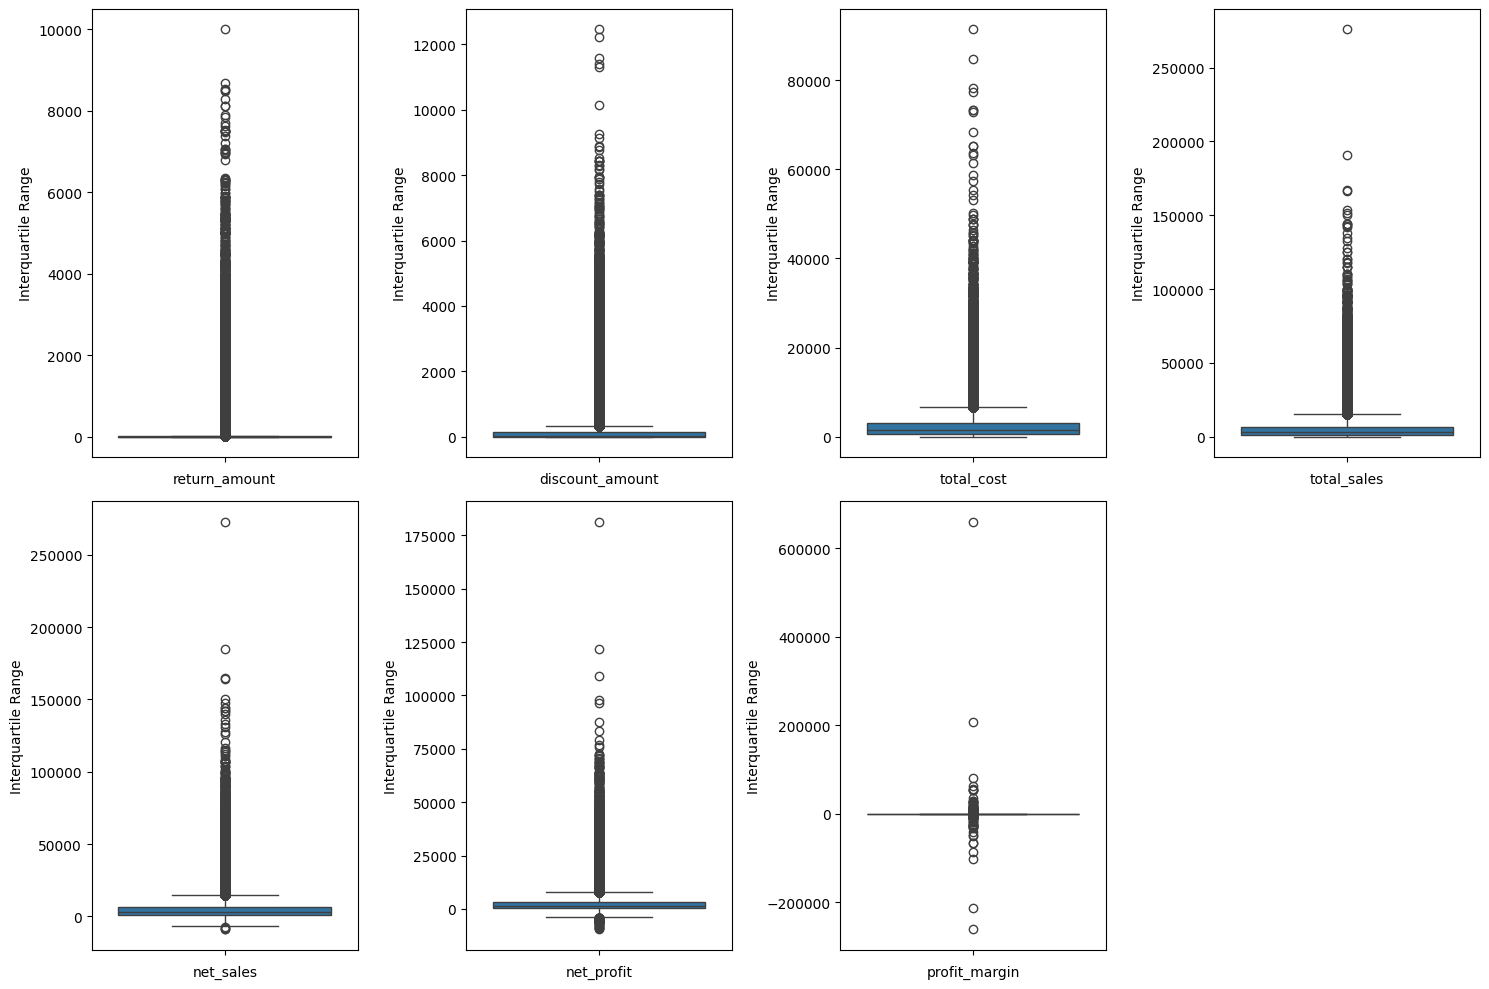

In [10]:
# Box plots for Numerical columns
numerical_cols = df.select_dtypes(include=["float64"]).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)  # Adjust Grid layout as needed
    sns.boxplot(y=df[col])
    plt.xlabel(col)
    plt.ylabel("Interquartile Range")
plt.tight_layout()
plt.show()

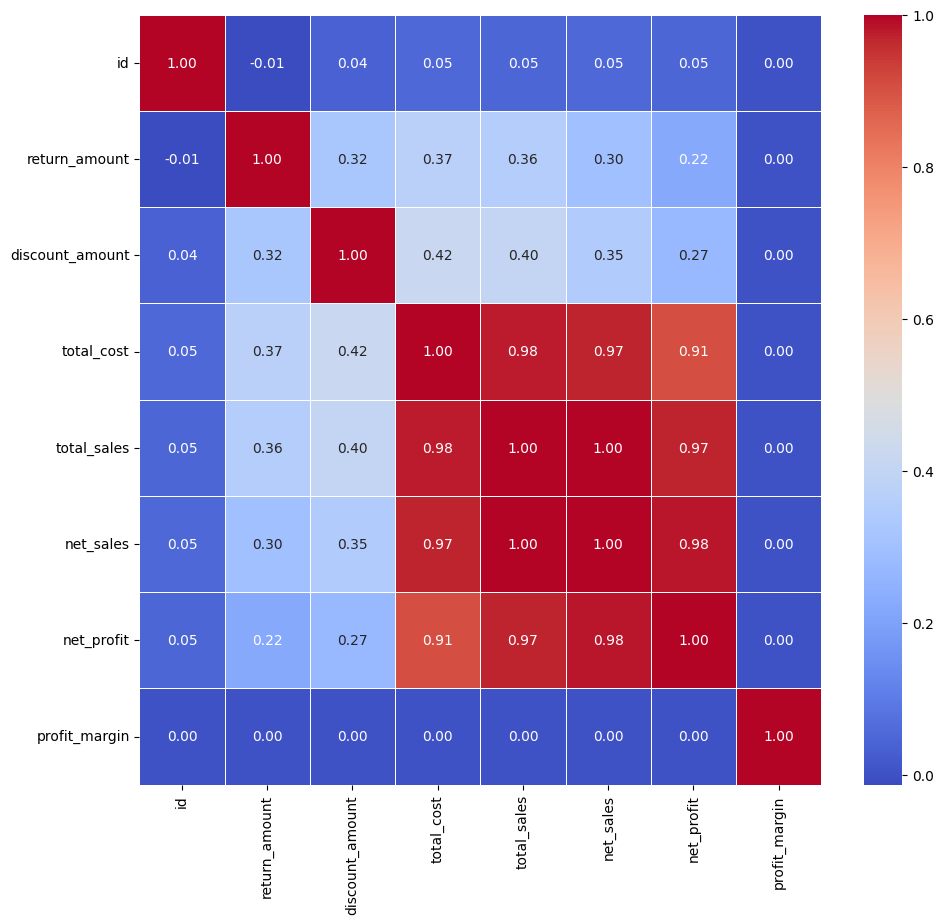

In [58]:
# correlation heatmap to find out relation between columns

plt.figure(figsize=(11, 10))
sns.heatmap(
    data=df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.show()

##### Correlation Insights
* Net Sales has weak correlation with Return Amount (0.30) and Discount Amount (0.35), which indicates that there is no significant impact of discounts and returns on sale.
* There is very strong correlation between Total Cost and Total Sales (0.98), Indicating that profit margin will stay about the same.